# Project: Loan Data From Prosper (Exploratory Analysis)

By Anas A. Mohaisin

## Table of Contents
<ul>
<li><a href="#overview">Dataset Overview</a></li>
<li><a href="#univariate">Univariate Exploration</a></li>
<li><a href="#bivariate">Bivariate Exploration</a></li>
<li><a href="#multivariate">Multivariate Exploration</a></li>
<li><a href="#model">XGBoost Classifier</a></li>
</ul>

### Preliminary Wrangling

This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.
The analysis concerns with exploring a dataset for loan values, borrower ARP, loan types, et cetera.

In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import requests
import os
import re
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
#from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

In [73]:
folder_name='mydata'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [75]:
url='https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv'
response=requests.get(url)
response

<Response [200]>

In [78]:
with open(os.path.join(folder_name,
                      url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)

In [2]:
pd.options.display.max_columns=None
df=pd.read_csv('./mydata/prosperLoanData.csv')
df.sample(3)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
71220,EB6F35534774979150B2EFB,616244,2012-07-24 16:09:35.543000000,NaN,36,Current,NaN,0.35797,0.3177,0.3077,0.28960,0.1725,0.11710,1.0,HR,5.0,19,FL,Professional,Employed,54.0,True,False,NaN,2012-07-24 16:09:31,660.0,679.0,1993-11-05 00:00:00,21.0,21.0,30.0,17,766.0,0.0,3.0,1.0,1035.0,0.0,0.0,0.0,20507.0,0.85,1976.0,26.0,0.96,0.0,0.26,"$75,000-99,999",True,8125.000000,990B36567608742373CE61E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,20,71705,4000,2012-07-31 00:00:00,Q3 2012,DE2135541468209866811AB,173.71,3300.49,1647.67,1652.82,-52.04,0.0,0.0,0.0,0.0,1.0,0,0,0.0,19
59017,9F6C3601237662920DF5380,1185851,2014-02-10 08:46:37.267000000,NaN,60,Current,NaN,0.18938,0.1655,0.1555,0.14559,0.0674,0.07819,4.0,C,4.0,7,MA,Other,Self-employed,44.0,True,False,NaN,2014-02-10 08:46:37,700.0,719.0,1996-03-22 00:00:00,4.0,4.0,18.0,4,82.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,400.0,0.26,1125.0,14.0,0.50,0.0,NaN,"$50,000-74,999",False,4166.666667,09DB3706086501199094EFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1,132362,15000,2014-02-19 00:00:00,Q1 2014,0FCC3705480853370663D2E,369.17,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
11388,C9063593816242303F03FFF,1003277,2013-11-07 16:46:02.827000000,NaN,60,Current,NaN,0.13227,0.1099,0.0999,0.09628,0.0324,0.06388,6.0,A,7.0,1,MN,Administrative Assistant,Employed,211.0,True,False,NaN,2013-11-07 16:46:05,800.0,819.0,1988-12-26 00:00:00,21.0,18.0,53.0,12,336.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,21287.0,0.14,27570.0,47.0,1.00,0.0,0.26,"$50,000-74,999",True,4194.000000,8C633701540964084728A5F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,3,121630,9500,2013-12-12 00:00:00,Q4 2013,23B23581692580183B22A1F,206.51,413.02,236.78,176.24,-16.04,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


In [80]:
print(df.shape)
print(df.dtypes)
print(df.head(10))

(113937, 81)
ListingKey                      object
ListingNumber                    int64
ListingCreationDate             object
CreditGrade                     object
Term                             int64
                                ...   
PercentFunded                  float64
Recommendations                  int64
InvestmentFromFriendsCount       int64
InvestmentFromFriendsAmount    float64
Investors                        int64
Length: 81, dtype: object
                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   
5  0F05359734824199381F61D        1074836  2013-12-14 08:26:37.093000000   


<a id='overview'></a>
## Dataset Overview

### What is the structure of your dataset?

There are 113,937 records for customers' loans information. The recorded data represent  81 various types of variables, i.e. discreet, continuous, and categorical with cardinality degree.
This dataset contains loans data for borrowers and lenders. Prosper is like other  Financial institutions a Risk-averse in nature. However, loans charged-off,  still, not wholly inevitable.
    
### What is/are the main feature(s) of interest in your dataset?

Relevant features to borrows rate which may motivate both the individual and Prosper to make a deal.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Borrow rate, Loan Amount and the loan status would help in data investigation. Using ML for Loan status prediction

<a id='univariate'></a>
## Univariate Exploration

mean        0.192764
skew        0.275994
kurtosis   -0.906859
Name: BorrowerRate, dtype: float64


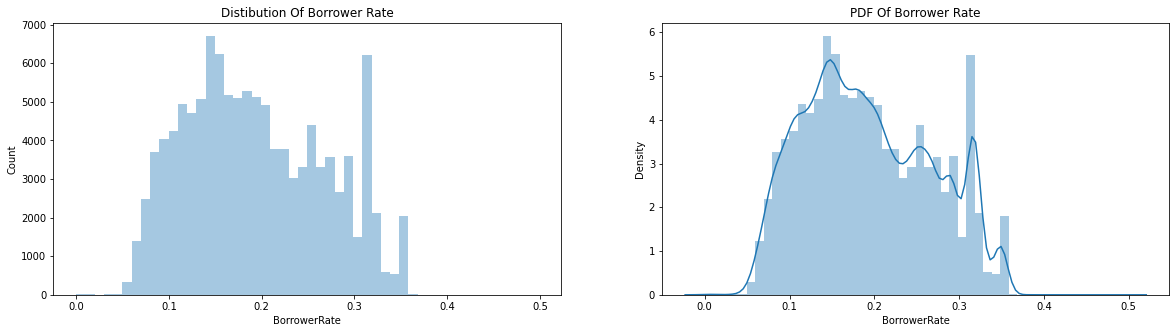

In [81]:
#print(df_enhanced_cln[['retweet','favourite']].agg(['mean','skew']))
plt.figure(figsize = [20, 5])
print(df.BorrowerRate.agg(['mean','skew','kurtosis']))
plt.subplot(1, 2, 1)
sns.distplot(df['BorrowerRate'],kde=False)
plt.title('Distibution Of Borrower Rate')
plt.ylabel('Count');

plt.subplot(1, 2, 2)
sns.distplot(df['BorrowerRate'])
plt.title('PDF Of Borrower Rate')
plt.ylabel('Density');

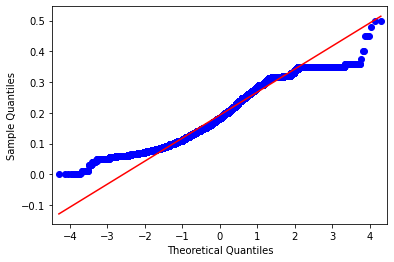

In [82]:
qqplot(df.BorrowerRate, line='s');

In [83]:
stat, p = shapiro(df.BorrowerRate)
print('\nShapiro-Wilk test: \nStatistics=%.3f, p=%.3f' % (stat, p))


Shapiro-Wilk test: 
Statistics=0.968, p=0.000


The distibution of Borrower Rate show  Platykurtic cf. Mesokurtic. This data voilates the normality assumption
as per Q_Q plot. Based on Shapiro-Wilk, we also fail to accept the $H_0:$ Data is normaly distributed.
    
Borrower rate PDF (probability density function, is positively skewed which means that Borrower rate is less than the average
(0.19).

**In other words, observed distribution differs from theoritical one**

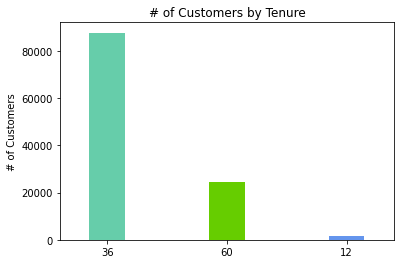

In [84]:
col_lst = [ '#66CDAA','#66CD00',  '#6495ED']
ax = df['Term'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3,color=col_lst)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Tenure');

It shows that 36-tenure type has the majority of customers then 60-tenure comes next.

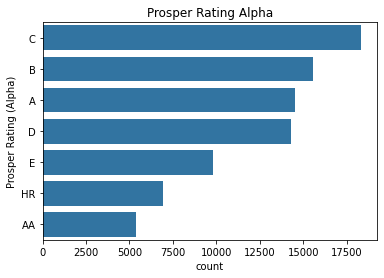

In [3]:
pr_counts=df['ProsperRating (Alpha)'].value_counts()
pr_order=pr_counts.index

base_colour=sns.color_palette()[0]
sns.countplot(data=df,y='ProsperRating (Alpha)',color=base_colour,order=pr_order)
plt.ylabel("Prosper Rating (Alpha)")
plt.title('Prosper Rating Alpha');

The majority of customers has "C" rating which represent the level of risk acceptable level 
of loan. It shows that the majority of accepted loan applications falls within 6.00-8.99% annual loss rate.

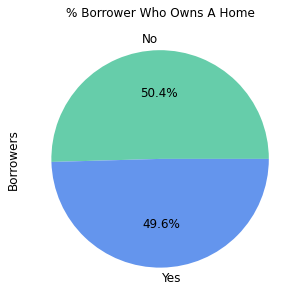

In [86]:
colours = [ '#66CDAA',  '#6495ED']
ax = (df['IsBorrowerHomeowner'].value_counts()*100.0 /len(df))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12,colors = colours) 

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Borrowers',fontsize = 12)
ax.set_title('% Borrower Who Owns A Home', fontsize = 12) ;

Prosper shows the proportion of borrowers who own a home is 50% approx.

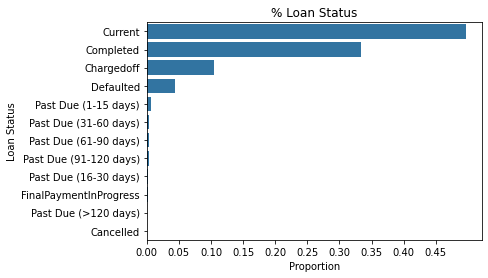

In [87]:
status_cnt=df['LoanStatus'].value_counts()
status_ord=status_cnt.index 

n_df=df.shape[0]
max_status_cnt=status_cnt[0]
max_props=max_status_cnt/n_df

tick_props=np.arange(0,max_props,0.05)
tick_names=['{:0.2f}'.format(i) for i in tick_props]

sns.countplot(data=df, y = 'LoanStatus', color=base_colour,order=status_ord);
plt.xticks(tick_props*n_df,tick_names)
plt.ylabel('Loan Status')
plt.xlabel('Proportion')
plt.title('% Loan Status');

Prosper dataset shows 10% of loans are charged-off while 35% is already completed/settled.

<a id='bivariate'></a>
## Bivariate Exploration

In [88]:
numeric_vars = ['Term','BorrowerRate','ProsperRating (numeric)','ProsperScore',
                'DebtToIncomeRatio','LoanOriginalAmount',
                'IsBorrowerHomeowner','IncomeVerifiable','EstimatedReturn','LP_InterestandFees']

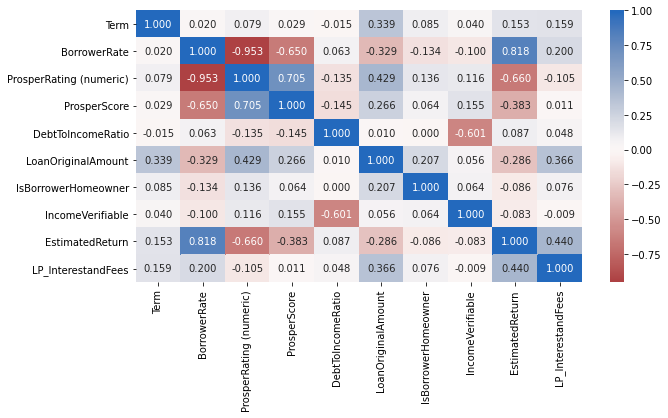

In [89]:
# correlation plot
plt.figure(figsize = [10, 5])
sns.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

The matrix shows positive correlation between the Loan Original Amount and (term, prosperRate, prosperScore, DebtToIncomeRatio,IsBorrowerHomeowner, IncomeVerifiable, and LP_InterestandFees). None of them has a strong correlation except the Prosper correlation which has a moderate correlation.
    
The matrix also shows negative and week correlation between the Loan Original Amount and (Borrower rate, EstimatedReturn, and Interesteandfees). 

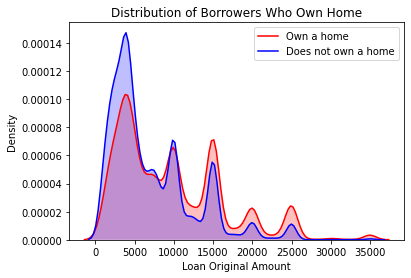

In [91]:
ax = sns.kdeplot(df.LoanOriginalAmount[(df["IsBorrowerHomeowner"] == True) ],
                color="Red", shade = True)
ax = sns.kdeplot(df.LoanOriginalAmount[(df["IsBorrowerHomeowner"] == False) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Own a home","Does not own a home"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Loan Original Amount')
ax.set_title('Distribution of Borrowers Who Own Home');

There is a lower loan amount for individuals who do not own home. 

      LoanOriginalAmount  EstimatedReturn
mean          8337.01385         0.096068
std           6245.80058         0.030403


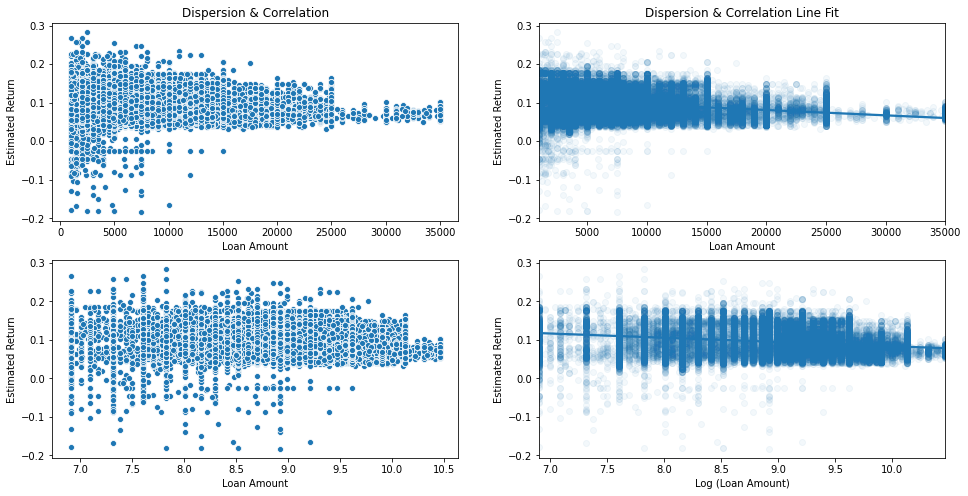

In [92]:
plt.figure(figsize = [16, 8])
print(df[['LoanOriginalAmount','EstimatedReturn']].agg(['mean','std']))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x="LoanOriginalAmount", y="EstimatedReturn")
plt.title("Dispersion & Correlation")
plt.xlabel("Loan Amount")
plt.ylabel("Estimated Return");

plt.subplot(2, 2, 2)
ax = sns.regplot(x="LoanOriginalAmount", y="EstimatedReturn", scatter_kws={'alpha':0.05},data=df)
plt.title("Dispersion & Correlation Line Fit")
plt.xlabel("Loan Amount")
plt.ylabel("Estimated Return");

df['lnLoan']=df['LoanOriginalAmount'].apply(np.log)

plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="lnLoan", y="EstimatedReturn")
plt.xlabel("Loan Amount")
plt.ylabel("Estimated Return");

plt.subplot(2, 2, 4)
ax = sns.regplot(x="lnLoan", y="EstimatedReturn", scatter_kws={'alpha':0.05},data=df)
plt.xlabel("Log (Loan Amount)")
plt.ylabel("Estimated Return");

Estimated Return disperses less with higher amount of money. Standard deviation shows is more than 15% from the mean. Log transformation shows consistant dispersion. In Financial institution(s), estimated return use this analysis to measure the volatility or returns and risk associated with assets.

By fitting a line, we see a negative slope thereof negative relationship between the two variables. 

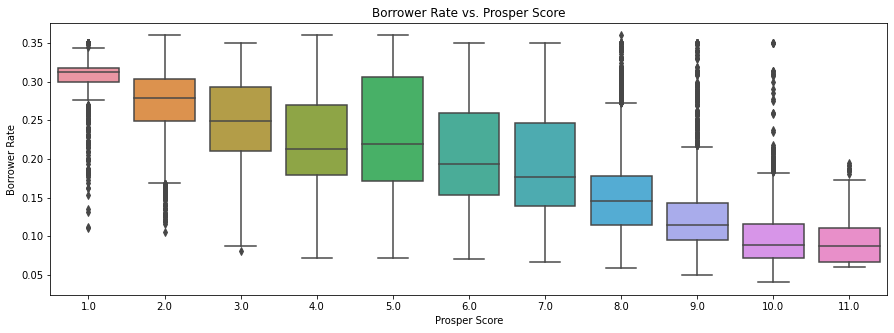

In [93]:
plt.figure(figsize = [15, 5]) 

sns.boxplot(data = df, x = 'ProsperScore', y = 'BorrowerRate')
plt.title('Borrower Rate vs. Prosper Score')
plt.xlabel('Prosper Score')
plt.ylabel('Borrower Rate');

There is a variability in 1.0, 2.0, 8.0, 9.0, and 10.0 for Prosper scores mean area and outliers. Also, notches also suggest that median differs from mean based on  CI 95%.

<a id='multivariate'></a>
## Multivariate Exploration

In [94]:
df['ListingCategory (numeric)'] = df['ListingCategory (numeric)'].replace({
    0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business',
    4: 'Personal Loan', 5: 'Student Use', 6: 'Auto', 7: 'Other', 8: 'Baby&Adoption', 9: 'Boat', 
    10: 'Cosmetic Procedure', 11: 'Engagement Ring', 12: 'Green Loans', 13: 'Household Expenses', 
    14: 'Large Purchases', 15: 'Medical/Dental',16: 'Motorcycle', 17: 'RV', 18: 'Taxes', 19: 'Vacation',
    20: 'Wedding Loans'})

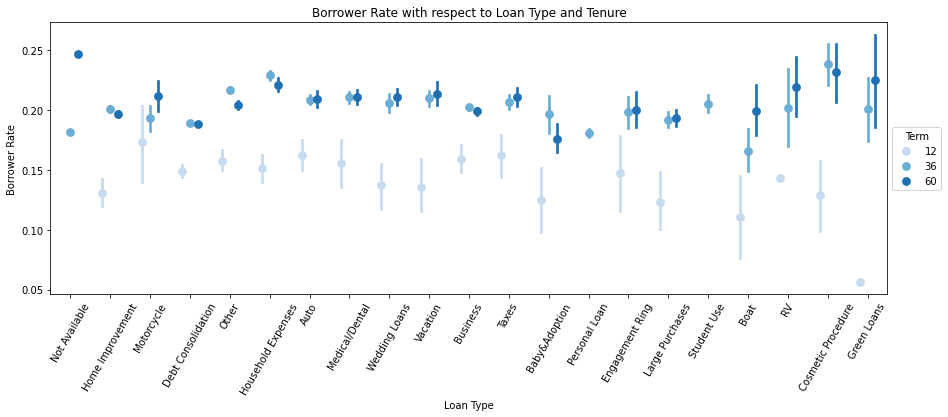

In [95]:
fig = plt.figure(figsize = [15,5])

ax = sns.pointplot(data = df, x = 'ListingCategory (numeric)', y = 'BorrowerRate',  hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4)

plt.title('Borrower Rate with respect to Loan Type and Tenure')
plt.xlabel('Loan Type')
plt.ylabel('Borrower Rate')
plt.xticks(rotation = 60)
# plot legend outside of figure
ax.legend(loc='center left', title='Term', bbox_to_anchor=(1, 0.5))
plt.show();

We conclude that:<br>
1. 60-tenure has higher Borrower rate.
2. Cosmetic procedure and Green loans have the highest Borrower Rate.

<a id='model'></a>
## XGBoost Classifier

In this part we will explore data about processed by Prosper loan. Based on this data we will try to predict either the loan status will be completed or charged-off.<br>
    
**Building a classification model using XGBoost classifier**

In [20]:
df=df.query("(LoanStatus == 'Chargedoff') | (LoanStatus == 'Completed')")

df['LoanStatus'].replace(to_replace='Chargedoff', value=1, inplace=True)
df['LoanStatus'].replace(to_replace='Completed',  value=0, inplace=True)

Feature = df[['LoanOriginalAmount',
        'LP_CustomerPayments','LP_CustomerPrincipalPayments','LP_InterestandFees']]
Feature = pd.concat([Feature,pd.get_dummies(df['IsBorrowerHomeowner'])], axis=1)
X = Feature[['LoanOriginalAmount',
             'LP_CustomerPayments','LP_CustomerPrincipalPayments','LP_InterestandFees',True, False]]

y = df['LoanStatus']

In [21]:
df.LoanStatus.value_counts()

0    38074
1    11992
Name: LoanStatus, dtype: int64

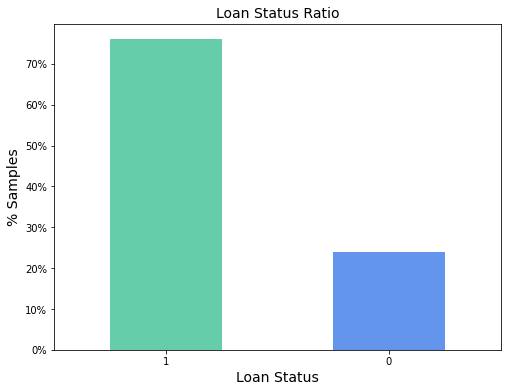

In [7]:
colours = [ '#66CDAA',  '#6495ED']

ax = (df['LoanStatus'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colours, figsize = (8,6),rot=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Samples',size = 14)
ax.set_xlabel('Loan Status',size = 14)
ax.set_title('Loan Status Ratio', size = 14);

New classified data shows that 24% of Prosper are charged-off.

**XGBoost Classifier Model Building**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\nAccuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 99.31%


Accuracy score is high which means that correct prediction/total number of predictions = 99.31%
    
$Accuracy = \frac{(TP+TN)}{(TP+FP+FN+TN)}$

In [9]:
X_train.head(3)

,LoanOriginalAmount,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,True,False
52047,7000,8310.35,7000.02,1310.33,0,1
19743,5000,7183.68,4589.12,2594.56,0,1
102145,2500,3112.52,2499.96,612.56,0,1


In [10]:
model = XGBClassifier()

model.fit(X_train[['LoanOriginalAmount']], y_train)
y_pred = model.predict(X_test[['LoanOriginalAmount']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.86%


In [48]:
y_pred = model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix")
print(confusion_matrix)


 Confusion Matrix
[[11368    42]
 [   61  3549]]


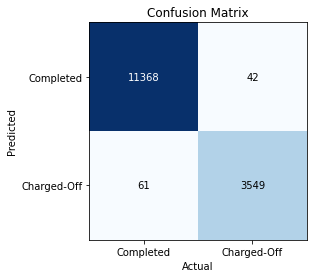

In [38]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

binary = confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=binary)
labels = ['Completed', 'Charged-Off']
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confusion matrix, diagonally, shows TP and TN. Out of 50,066, model predicts that 11,368 are Completed (not charged-off) and 3549 are charged-off, 

Average precision-recall score: 0.98


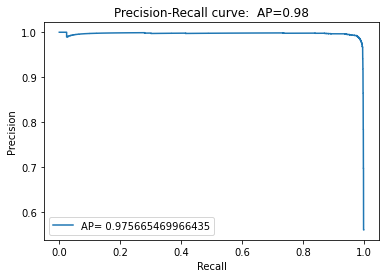

In [43]:
avg_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(avg_precision))

disp = plot_precision_recall_curve(model, X_test, y_test,label="AP= "+str(avg_precision))
disp.ax_.set_title('Precision-Recall curve: '' AP={0:0.2f}'.format(avg_precision))
plt.legend();

**Specificity and Sensitivity**

Precision-Recall curve shows high precision relates to a low false positive rate, and high recall relates to a low false negative rate, i.e. tradeoff between precision and recall.